In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import networkx as nx
import itertools
import random
import math
import numpy as np
from graphing_utils import *
from capsule_utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cpu


In [3]:
class S_I(torch.nn.Module):
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name):
        super(S_I,self).__init__()
        self._contact_net = contact_net
        self._pinf = pinf
        self._n = self._contact_net.size()[0]
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        
    def forward(self, states):
        I = states[self._states_names['I']] # boolean state of being infected
        susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
        infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
        dI = I*infectiveness
        dI = 1 - (1 - self._contact_net.to_dense()*dI.unsqueeze(dim=1).matmul(susceptiveness.unsqueeze(dim=1).t())).prod(dim=0) # probability of being infected in that day
        dI = torch.rand(self._n).to(device) < dI.squeeze() # whether or not infected that day
        
        I = torch.max(I, dI) 
        states[self._states_names['I']] = I
        return states

In [4]:
class I_S(torch.nn.Module):
    def __init__(self, contact_net, I_name, R_name, recover_time_name):
        super(I_S,self).__init__()
        self._contact_net = contact_net
        self._n = self._contact_net.size()[0]
        self._states_names = {'I': I_name, 'R': R_name, 'recover_time': recover_time_name}
        
    def forward(self, states):
        R = states[self._states_names['R']]
        I = states[self._states_names['I']]
        recover_time = states[self._states_names['recover_time']]
        R = F.relu(R-1)
        R = torch.where((I==1) & (R==math.inf), recover_time, R) # setting recovery time for those newly infected  
        I = torch.where((R==0), torch.zeros(self._n).to(device), I)
        R = torch.where((R==0), torch.ones(self._n).to(device)*math.inf, R) # reset recovery times for those who are susceptible again
        states[self._states_names['R']] = R
        states[self._states_names['I']] = I
        return states

In [5]:
class ControllingState_SusceptivenessInfectiveness(torch.nn.Module):
    def __init__(self, controlling_state_name, susceptiveness_name, infectiveness_name, susceptiveness_prob, infectiveness_prob):
        super(ControllingState_SusceptivenessInfectiveness, self).__init__()
        self._susceptiveness_prob = susceptiveness_prob
        self._infectiveness_prob = infectiveness_prob
        
        # if a person is in controlling_state, that person's infectiveness and susceptiveness will change from the default
        self._states_names = {"controlling_state": controlling_state_name, "susceptiveness": susceptiveness_name, "infectiveness": infectiveness_name}
            
    def forward(self, states):
        controlling_state = states[self._states_names['controlling_state']]
        susceptiveness = states[self._states_names['susceptiveness']]
        infectiveness = states[self._states_names['infectiveness']]
        
        susceptiveness[(controlling_state==1)] = self._susceptiveness_prob
        infectiveness[(controlling_state==1)] = self._infectiveness_prob
        return states

In [6]:
class Friends_SusceptivenessInfectiveness(torch.nn.Module):
    def __init__(self, contact_net, friends_state_name, num_friends, susceptiveness_name, infectiveness_name, susceptiveness_prob, infectiveness_prob):
        super(Friends_SusceptivenessInfectiveness, self).__init__()
        self._contact_net = contact_net
        self._susceptiveness_prob = susceptiveness_prob
        self._infectiveness_prob = infectiveness_prob
        self._num_friends = num_friends # minimum number of friends in friends_state needed for a person's infectiveness and susceptiveness to change
        
        # if enough friends are in state friends_state, a person's infectiveness and susceptiveness will change
        self._states_names = {"friends_state": friends_state_name, "susceptiveness": susceptiveness_name, "infectiveness": infectiveness_name}
        
    def forward(self, states):
        friends_state = states[self._states_names['friends_state']]
        susceptiveness = states[self._states_names['susceptiveness']]
        infectiveness = states[self._states_names['infectiveness']]
        
        friends_infected = self._contact_net.mm(friends_state.unsqueeze(dim=1))
        enough_friends_infected = (friends_infected.squeeze() >= self._num_friends)
        susceptiveness[enough_friends_infected] = self._susceptiveness_prob
        infectiveness[enough_friends_infected] = self._infectiveness_prob
        return states

In [20]:
n = 2000
pinf_bio = 0.2
psus_bio = 0.2
pinf_nomask_bio = 0.4
psus_nomask_bio = 0.4
recover_time_bio = 9.3
I_name_bio = "infected_covid"
R_name_bio = "remaining_recovery_time"
susceptiveness_name_bio = "susceptiveness_covid"
infectiveness_name_bio = "infectiveness_covid"
recover_time_name_bio = "recovery_times_time"

pinf_socio = 0.4
psus_socio = 0.4
recover_time_socio = 5 
critical_number_friends = 3
pinf_friendsinfected_socio = 0.2
psus_friendsinfected_socio = 0.2
I_name_socio = "antimask"
R_name_socio = "remaining_antimask_time"
susceptiveness_name_socio = "persuadability"
infectiveness_name_socio = "persuasiveness"
recover_time_name_socio = "lifetimes_staying_persuaded"

maxt = 75

def initializations(pinf, psus, avg_recover_time, I_name, R_name, susceptiveness_name, infectiveness_name, recover_time_name):
    recover_time = F.relu(torch.distributions.normal.Normal(avg_recover_time,2).rsample((n,)).to(device))
    I = torch.zeros(n).to(device)
    R = torch.ones(n).to(device) * math.inf
    seed = random.randint(0, n-1)
    I[seed]=1
    susceptiveness = torch.ones(n).to(device)*psus
    infectiveness = torch.ones(n).to(device)*pinf
    return  {I_name: I, R_name: R, recover_time_name: recover_time, susceptiveness_name: susceptiveness, infectiveness_name: infectiveness}            

In [21]:
m_bio = 10*n # number of connections in contact matrix
idx = torch.randint(n,(2,m_bio)).to(device)
con_bio = torch.sparse.FloatTensor(idx,torch.ones(m_bio).to(device),torch.Size([n,n])).to(device)

m_socio = 10*n
idx = torch.randint(n,(2,m_socio)).to(device)
con_socio = torch.sparse.FloatTensor(idx,torch.ones(m_socio).to(device),torch.Size([n,n])).to(device)

In [22]:
def sim(repeats=1):
    with torch.no_grad():
        final_log = []
        
        for _ in range(repeats):
            states = initializations(pinf=pinf_bio, psus=psus_bio, avg_recover_time=recover_time_bio, recover_time_name=recover_time_name_bio, I_name=I_name_bio, R_name=R_name_bio, susceptiveness_name=susceptiveness_name_bio, infectiveness_name=infectiveness_name_bio) # bio states
            states.update(initializations(pinf=pinf_socio, psus=psus_socio, avg_recover_time=recover_time_socio, recover_time_name=recover_time_name_socio, I_name=I_name_socio, R_name=R_name_socio, susceptiveness_name=susceptiveness_name_socio, infectiveness_name=infectiveness_name_socio)) # adding social states
            assert len(states) == 10 # check against duplicate names
            
            si_bio = S_I(contact_net=con_bio, pinf=pinf_bio, I_name=I_name_bio, susceptiveness_name=susceptiveness_name_bio, infectiveness_name=infectiveness_name_bio)
            si_socio = S_I(contact_net=con_socio, pinf=pinf_socio, I_name=I_name_socio, susceptiveness_name=susceptiveness_name_socio, infectiveness_name=infectiveness_name_socio)
            is_socio = I_S(contact_net=con_socio, I_name=I_name_socio, R_name=R_name_socio, recover_time_name=recover_time_name_socio)
            sis_socio = torch.nn.Sequential(si_socio, is_socio)
            socio_to_bio = ControllingState_SusceptivenessInfectiveness(controlling_state_name=I_name_socio, susceptiveness_name=susceptiveness_name_bio, infectiveness_name=infectiveness_name_bio, susceptiveness_prob=psus_nomask_bio, infectiveness_prob=pinf_nomask_bio)
            bio_to_socio = Friends_SusceptivenessInfectiveness(contact_net=con_bio, num_friends=critical_number_friends, friends_state_name=I_name_bio, susceptiveness_name=susceptiveness_name_bio, infectiveness_name=infectiveness_name_bio, susceptiveness_prob=psus_friendsinfected_socio, infectiveness_prob=pinf_friendsinfected_socio)
            si_bio_sis_socio = torch.nn.Sequential(si_bio, sis_socio, socio_to_bio)
            
            # use below if want bio to social connection as well
            #si_bio_sis_socio = torch.nn.Sequential(si_bio, sis_socio, socio_to_bio, bio_to_socio)
            
            log = []
            for _ in range(maxt):
                states = si_bio_sis_socio(states)
                log.append(torch.stack((states[I_name_bio], states[I_name_socio])))
                
            final_log.append(torch.stack(log))
        final_log = torch.stack(final_log)
    return final_log

torch.Size([15, 75, 2])


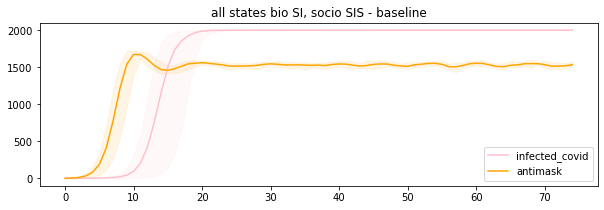

In [23]:
colors = [("pink",I_name_bio), ("orange",I_name_socio)]
age_sizes = [n]

log = sim(15)
plot(log, colors, age_sizes, by_age=False, title="bio SI, socio SIS - baseline")

torch.Size([15, 75, 2])


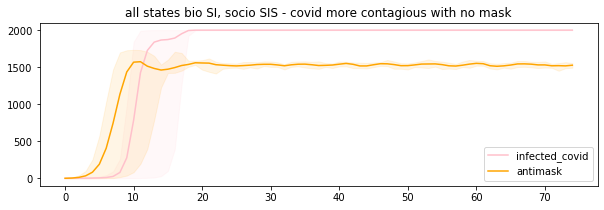

In [25]:
psus_nomask_bio = 0.7
pinf_nomask_bio = 0.7
log = sim(15)
plot(log, colors, age_sizes, by_age=False, title="bio SI, socio SIS - covid more contagious with no mask")

In [30]:
T = time.time()
log = sim(10)
print(time.time()-T)

44.511980056762695
